







         Привет уважаемая команда! Сопроводительная заметка пояснение:


         
      Здесь я ввел свои дополнительные элементы в дизайн,  что бы показать, найденую и усвоеную мной 
    посследовательно проверок и рассуждений в ЭТОМ виде вопроса. Если у вас другое опытное мнение, пожалуйста, 
    дайте обратную связь, она будет очень ценной для меня!

    Как и ранее, для вас ( и по своей привычке ),я все подробно описываю, читайте неторопливо, я старался.
        Моя цель ,по прежнему, донести способ рассуждения, а не короткий вывод.  Если есть ошибки в расчетах 
        или оценках показатели, прошу учитывать новизну материала, не ругать, и просто дать разъяснения.

    Исторически сложилось , что в первую очередь, меня заботила наука принятия решения в условиях извечной 
    асимметрии информации и собственной «возможности ошибиться». Поэтому стараюст понимть и контролировать то, 
    КАКИЕ ошибки и КОГДА я допускаю. Мне хочется верить, это важнейший навык для исследователя.	
    Помогают мне в  этом, мои товарищи Канеман, Тверски, Талеб, еще с 10х годов. 
    Сейчас более плотно знакомлюсь со статистикой и визуализацией. 

   

                                                            импортирую и подключаюсь
                                                            

In [2]:
import pandas as pd
import numpy as np
import pandahouse
import matplotlib.pyplot as plt
import scipy.stats as stats

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20221220'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') AS likes,
    sum(action = 'view') AS views,
    likes/views AS ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-12-02' AND toDate(time) <= '2022-12-08'
    AND exp_group IN (0,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

#сомтрим количество наблюдений в группах
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
0,9999,9999,9999,9999
3,10049,10049,10049,10049


In [3]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns

In [4]:
#     ЗАДАЧА  1
#     Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? 
#     Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [5]:
df.query('exp_group == 0')['likes']

2         8
3         5
4        18
5        13
6        21
         ..
20038    35
20039    15
20040    13
20041     8
20045     7
Name: likes, Length: 9999, dtype: uint64

In [6]:
# 1) Считаем общий CTR в контрольной группе 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)

ctr_control_0group = df.query('exp_group == 0')['likes'].sum() / df.query('exp_group == 0')['views'].sum()



# 2) Посчитаем в обеих группах поюзерную метрику 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠
# linear_df = pd.DataFrame()
                            
df['linearized_likes_0'] = (df.query('exp_group == 0')['likes']) -( ctr_control_0group * df.query('exp_group == 0')['views']) 
df['linearized_likes_3'] = (df.query('exp_group == 3')['likes']) - (ctr_control_0group * df.query('exp_group == 3')['views'] )



# 3) После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

stats.levene(df.query('exp_group ==0').ctr, df.query('exp_group ==3').ctr)  #equal_var = FalsE
 
p_val_before = stats.ttest_ind(df.query('exp_group == 0')['ctr'], df.query('exp_group == 3')['ctr'], equal_var = False)
p_val_after = stats.ttest_ind(df.query('exp_group == 0')['linearized_likes_0'], df.query('exp_group == 3')['linearized_likes_3'], equal_var = False)

print(f' p_val_before linea-n {p_val_before[1]}, and p_val_after linea-n {p_val_after[1]}')

LeveneResult(statistic=10.953080887745209, pvalue=0.0009361288519049566)

 p_val_before linea-n 1.055849414662529e-43, and p_val_after linea-n 5.4914249479687664e-52


In [7]:
#     ЗАДАНИЕ 2

# Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? 
# Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [8]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') AS likes,
    sum(action = 'view') AS views,
    likes/views AS ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-12-02' AND toDate(time) <= '2022-12-08'
    AND exp_group IN (1,2)
GROUP BY exp_group, user_id
"""

df1 = pandahouse.read_clickhouse(q, connection=connection)

#сомтрим количество наблюдений в группах
df1.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


In [9]:
# 1) Считаем общий CTR в контрольной группе 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)

ctr_control_1group = df1.query('exp_group == 1')['likes'].sum() / df1.query('exp_group == 1')['views'].sum()



# 2) Посчитаем в обеих группах поюзерную метрику 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠
# linear_df = pd.DataFrame()


df1['linearized_likes_1'] = (df1.query('exp_group == 1')['likes']) -( ctr_control_1group * df1.query('exp_group == 1')['views']) 
df1['linearized_likes_2'] = (df1.query('exp_group == 2')['likes']) - (ctr_control_1group * df1.query('exp_group == 2')['views'] )



# 3) После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

p_val_after = stats.ttest_ind(df1.query('exp_group == 1')['linearized_likes_1'], df1.query('exp_group == 2')['linearized_likes_2'], equal_var = False)
p_val_afte1 = stats.mannwhitneyu(df1.query('exp_group == 1')['linearized_likes_1'], df1.query('exp_group == 2')['linearized_likes_2'])

p_val_before = stats.ttest_ind(df1.query('exp_group == 1')['ctr'], df1.query('exp_group == 2')['ctr'], equal_var = False)
p_val_before1 = stats.mannwhitneyu(df1.query('exp_group == 1')['ctr'], df1.query('exp_group == 2')['ctr'])




print(f' p_val_before linea-n {p_val_before[1]} , and p_val_after linea-n {p_val_after[1]}')
print(f' p_val_before linea-n {p_val_before1[1]}, and p_val_after linea-n {p_val_afte1[1]}')

 p_val_before linea-n 0.47806231308750413 , and p_val_after linea-n 9.439432187037712e-10
 p_val_before linea-n 6.0376484617779035e-56, and p_val_after linea-n 9.404319579641738e-27


In [10]:
# ИТОГО 

#     ЗДЕСЬ  я использовал тест манн утни ибо распределения 2 групп слишком различны и  предварительно  я их
#     не преобразовавывал ,как в предудыщей работе.





       ВЫВОД 3


    так уж и быть, в принципе, можно сравнить p value меры тенденции двух разных метрик, 
       1) из за их общей  склонности к отношению между клик /вью. 
       2) общих исходных данных
          Однако не стоит забывать,что это держиться на корреляции,
    и у линеаризации есть свои допущения, поэтому нос по ветру и быть на чеку

In [12]:
# - сравни рапсределния их ДО и ПОСЛЕ визул
# - используй преобразование во втором случае,для сравнения результатов манна и т теста

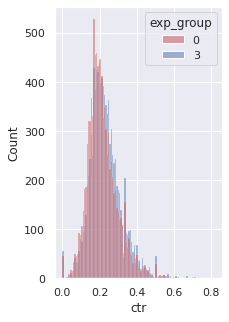

In [13]:
#     BEFORE  linearizing 0 3

# sns.histplot( df.query('exp_group == 0'), x = "ctr", pallete= ['c', 'r'])
# sns.histplot( df.query('exp_group == 3') , x = "ctr")
sns.set(rc={'figure.figsize':(3 ,5)})
sns.histplot(data = df[['ctr', 'exp_group']], 
                      x='ctr', hue='exp_group', palette = ['r', 'b'],
                      alpha=0.5, kde=False)


/opt/tljh/user/lib/python3.7/site-packages/seaborn/palettes.py:222: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  palette = _ColorPalette(palette)


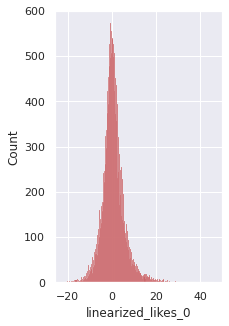

In [14]:
#     AFETR linearizing 0 3

sns.set(rc={'figure.figsize':(3 ,5)}, palette = ['r', 'C'])
# p_val_after = stats.ttest_ind(df.query('exp_group == 0')['linearized_likes_0'], df.query('exp_group == 3')['linearized_likes_3'], equal_var = False)

sns.histplot(data = df['linearized_likes_0'])
sns.histplot(data = df['linearized_likes_3'])



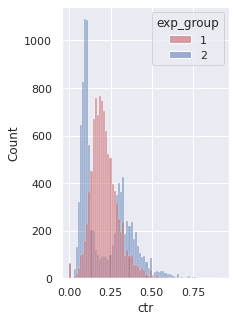

In [15]:
#     BEFORE  linearizing 1 2

# sns.histplot( df.query('exp_group == 0'), x = "ctr", pallete= ['c', 'r'])
# sns.histplot( df.query('exp_group == 3') , x = "ctr")
sns.set(rc={'figure.figsize':(3 ,5)})
sns.histplot(data = df1[['ctr', 'exp_group']], 
                      x='ctr', hue='exp_group', palette = ['r', 'b'],
                      alpha=0.5, kde=False)


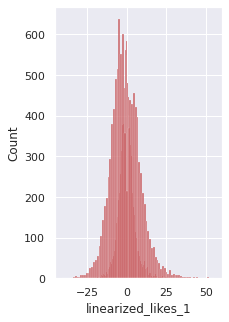

In [16]:
#     AFETR  linearizing 1 2

sns.set(rc={'figure.figsize':(3 ,5)}, palette = ['r', 'b'])
# p_val_after = stats.ttest_ind(df.query('exp_group == 0')['linearized_likes_0'], df.query('exp_group == 3')['linearized_likes_3'], equal_var = False)

sns.histplot(data = df1['linearized_likes_1'])
sns.histplot(data = df1['linearized_likes_2'])



/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


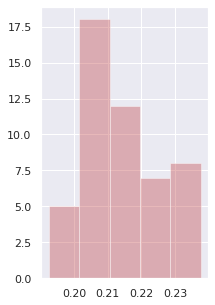

In [17]:
#   T SCORES


t_scores = []
sample_size = 150
#se = sigma / sample_size**0.5
Mu = df1.query('exp_group ==2')['ctr'].mean()
for i in range(50):
    sample_real = np.random.choice(df1.query('exp_group ==2')['ctr'], sample_size, False )
    
    sample_mean_real = sample_real.mean()  #For each sample CALCULATE OWN MEAM AND STD!
    samle_std_real = sample_real.std()
    
    se_real = samle_std_real/sample_size**0.5   #iinstead Sigma/n**0.5 indicate EACH samle_std_real
                                #which can  consider as  Sigma of Population for each separate Sample !!!!
    
#     t_score = (sample_mean_real - Mu)/se_real
#     t_scores.append(t_score)
    t_scores.append(sample_mean_real)



sns.distplot(t_scores, kde = False)



/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


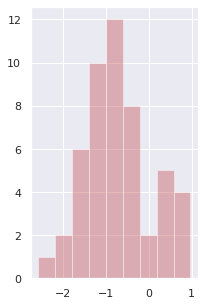

In [18]:
#   T SCORES


t_scores = []
sample_size = 150
#se = sigma / sample_size**0.5
Mu = df1.query('exp_group ==2')['ctr'].mean()
for i in range(50):
    sample_real = np.random.choice(df1.query('exp_group ==2')['linearized_likes_2'], sample_size, False )
    
    sample_mean_real = sample_real.mean()  #For each sample CALCULATE OWN MEAM AND STD!
    samle_std_real = sample_real.std()
    
    se_real = samle_std_real/sample_size**0.5   #iinstead Sigma/n**0.5 indicate EACH samle_std_real
                                #which can  consider as  Sigma of Population for each separate Sample !!!!
    
#     t_score = (sample_mean_real - Mu)/se_real
    t_scores.append(sample_mean_real)

    


sns.distplot(t_scores, kde = False)

